# Jigsaw test

In [1]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely import geometry, ops
import geopandas as gp
import xarray as xr
from pyPoseidon.dem import *
from pyPoseidon.meteo import *

In [3]:
import subprocess
from shutil import copyfile

In [4]:
#%matplotlib notebook

## create input .msh

In [5]:
#Define the coastline shapefile
shapefile = '/Users/brey/DATA/COASTLINES/naturalearth/coastline/ne_%sm_coastline' % \
                    {'l':110, 'i':50, 'h':10}['i']

In [6]:
#read it into a DataFrame
shp = gp.GeoDataFrame.from_file(shapefile+'.shp')


In [7]:
shp['length']=shp['geometry'][:].length # optional

In [8]:
shp = shp.sort_values(by='length', ascending=0) #optional
shp = shp.reset_index(drop=True)

In [9]:
#put all Lines in a list
ls=[]
for i in range(shp.shape[0]):
    il = shp.loc[i,'geometry']
    try:
        print len(il)
        for k in range(len(list(il.geoms))):
               ls.append(list(il.geoms)[k])
    except:
        ls.append(il)

2


In [10]:
sall = geometry.MultiLineString(ls) #join them into a Multiline

In [11]:
c = ops.linemerge(sall) #merge parts if possible

In [12]:
len(c)

1422

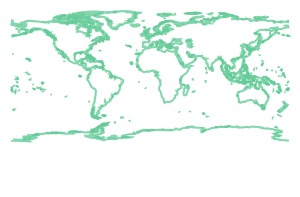

In [13]:
c #visualize

In [14]:
# lat/lon window
minlon = -79. 
maxlon =  -76.
minlat = 17.
maxlat = 19.

In [15]:
#create a polygon of the grid
grp=geometry.Polygon([(minlon,minlat),(minlon,maxlat),(maxlon,maxlat),(maxlon,minlat)])

In [16]:
cl=[] #initialize
#add Polygons if they intersect with the grid
for i in range(len(c)):
    z = geometry.Polygon(c[i])
    if z.intersects(grp): 
            cl.append(c[i])

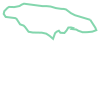

In [17]:
cll = geometry.MultiLineString(cl) #join them into a Multiline

cg = ops.linemerge(cll) #merge parts if possible

cg

In [18]:
lon=[]
lat=[]

for x,y in cg.coords[:]:
    lon.append(x)
    lat.append(y)

In [19]:
cg.coords[:]

[(-76.349853515625, 18.15185546875),
 (-76.70073242187499, 18.25717773437499),
 (-76.79326171874999, 18.30429687499999),
 (-76.908203125, 18.390429687500003),
 (-76.959375, 18.40185546875),
 (-77.01376953124999, 18.40292968749999),
 (-77.13955078125, 18.42148437499999),
 (-77.261474609375, 18.457421874999994),
 (-77.354248046875, 18.466455078124994),
 (-77.451611328125, 18.467041015625),
 (-77.8734375, 18.522216796875),
 (-77.92685546874999, 18.500683593749997),
 (-77.978173828125, 18.467822265625003),
 (-78.09453124999999, 18.44482421875),
 (-78.21669921875, 18.44809570312499),
 (-78.25244140625, 18.42626953125),
 (-78.32597656249999, 18.349755859374994),
 (-78.339501953125, 18.28720703124999),
 (-78.294091796875, 18.218066406250003),
 (-78.0736328125, 18.191162109375),
 (-78.04448242187499, 18.173828125),
 (-77.96298828124999, 18.047558593749997),
 (-77.881298828125, 18.01904296875),
 (-77.84941406249999, 17.987499999999997),
 (-77.76816406249999, 17.877392578124997),
 (-77.670751953

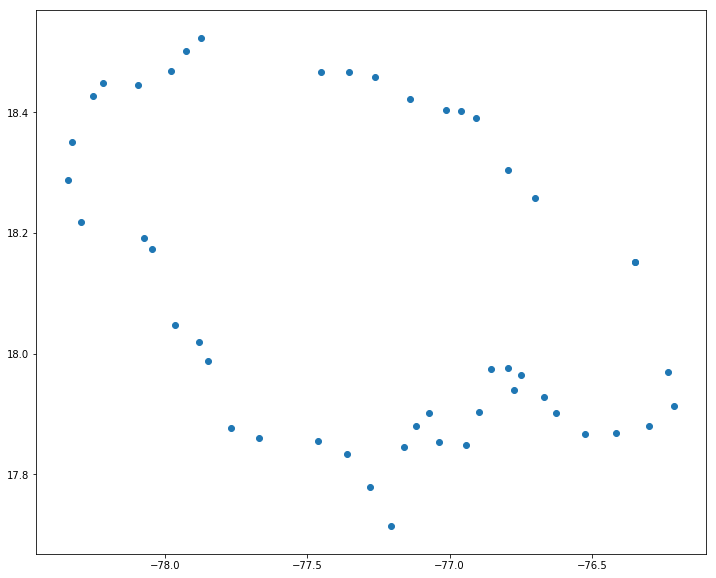

In [20]:
#plot xy points
plt.figure(figsize=(12,10))
plt.scatter(lon, lat)

## GEO.msh file 

In [21]:
box = pd.DataFrame([[minlon,minlat],[maxlon,minlat],[maxlon,maxlat],[minlon,maxlat]],columns=['lon','lat'])

In [22]:
box

,lon,lat
0,-79.0,17.0
1,-76.0,17.0
2,-76.0,19.0
3,-79.0,19.0


In [23]:
df = box.append(pd.DataFrame({'lon':lon,'lat':lat}))

In [24]:
df['z']=0

In [25]:
df.reset_index(inplace=True)

In [26]:
df.head()

,index,lat,lon,z
0,0,17.000000,-79.000000,0
1,1,17.000000,-76.000000,0
2,2,19.000000,-76.000000,0
3,3,19.000000,-79.000000,0
4,0,18.151855,-76.349854,0


In [27]:
df.tail()

,index,lat,lon,z
47,43,17.868213,-76.415527,0
48,44,17.879834,-76.301465,0
49,45,17.913525,-76.210791,0
50,46,17.970312,-76.232764,0
51,47,18.151855,-76.349854,0


In [28]:
df.shape

(52, 4)

In [29]:
msh='/Users/brey/Downloads/JIGSAW/geo/Jamaica-GEOM.msh'

In [30]:
# write header
with open(msh,'w') as f:
    f.write('MSHID=2;EUCLIDEAN-MESH\n')
    f.write('NDIMS=2\n')
    f.write('POINT={}\n'.format(df.shape[0]))    

In [31]:
with open(msh, 'a') as f:
    df.to_csv(f, index=False, header=0, columns=['lon','lat','z'],sep=';')

In [32]:
box = pd.DataFrame([[0,1,0],[1,2,0],[2,3,0],[3,0,0]])

In [33]:
# get edges
edges = box.append(pd.DataFrame([[i,i + 1,0] for i in range(4, len(lon)+4)]))

In [34]:
edges.head()

,0,1,2
0,0,1,0
1,1,2,0
2,2,3,0
3,3,0,0
0,4,5,0


In [35]:
edges.tail()

,0,1,2
43,47,48,0
44,48,49,0
45,49,50,0
46,50,51,0
47,51,52,0


In [36]:
edges.iloc[-1][1]=4

In [37]:
# write header
with open(msh,'a') as f:
    f.write('EDGE2={}\n'.format(edges.shape[0]))

In [38]:
with open(msh, 'a') as f:
    edges.to_csv(f, index=False, header=0, sep=';')

## hfun file

In [39]:
xpos = np.linspace(minlon,maxlon,128)

In [40]:
ypos = np.linspace(minlat,maxlat,128)

In [41]:
XPOS,YPOS = np.meshgrid(xpos,ypos)

In [42]:
mlon = np.mean([minlon,maxlon])

In [43]:
mlat = np.mean([minlat,maxlat])

In [44]:
hfun =-.3*np.exp(-.1*(XPOS-mlon)**2 -.1*(YPOS-mlat)**2) + .4 
hfun

array([[ 0.18324179,  0.18171244,  0.18019682, ...,  0.18019682,
         0.18171244,  0.18324179],
       [ 0.18256341,  0.18102926,  0.1795089 , ...,  0.1795089 ,
         0.18102926,  0.18256341],
       [ 0.18189372,  0.18035485,  0.17882981, ...,  0.17882981,
         0.18035485,  0.18189372],
       ..., 
       [ 0.18189372,  0.18035485,  0.17882981, ...,  0.17882981,
         0.18035485,  0.18189372],
       [ 0.18256341,  0.18102926,  0.1795089 , ...,  0.1795089 ,
         0.18102926,  0.18256341],
       [ 0.18324179,  0.18171244,  0.18019682, ...,  0.18019682,
         0.18171244,  0.18324179]])

In [45]:
hf = pd.DataFrame({'xpos':xpos,'ypos':ypos})

In [46]:
hf.head()

,xpos,ypos
0,-79.000000,17.000000
1,-78.976378,17.015748
2,-78.952756,17.031496
3,-78.929134,17.047244
4,-78.905512,17.062992


In [47]:
ffun='/Users/brey/Downloads/JIGSAW/out/Jamaica-HFUN.msh'

In [48]:
# write header
with open(ffun,'w') as f:
    # BOX-HFUN.msh; created by JIGSAW's OCTAVE interface
    f.write('MSHID=3;EUCLIDEAN-GRID\n')
    f.write('NDIMS=2\n')
    f.write('COORD=1;128\n')

In [49]:
with open(ffun, 'a') as f:
    hf['xpos'].to_csv(f, index=False, header=0)

In [50]:
with open(ffun, 'a') as f:
    f.write('COORD=2;128\n')

In [51]:
with open(ffun, 'a') as f:
    hf['ypos'].to_csv(f, index=False, header=0)

In [52]:
with open(ffun, 'a') as f:
    f.write('VALUE=16384;1\n')

In [53]:
with open(ffun, 'a') as f:
    for i in range(hfun.size):
        f.write('{}\n'.format(hfun.flatten()[i]))

## Execute jigsaw

In [54]:
! /Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/bin/MAC-64/jigsaw64r /Users/brey/Downloads/JIGSAW/Jamaica.jig

 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation package.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.5

  Reading CFG. file...

  CFG. data summary...

  GEOM_FILE = /Users/brey/Downloads/JIGSAW/geo/Jamaica-GEOM.msh 
  MESH_FILE = /Users/brey/Downloads/JIGSAW/out/Jamaica.msh 
  HFUN_FILE = /Users/brey/Downloads/JIGSAW/out/Jamaica-HFUN.msh 

  GEOM_SEED = 8 
  GEOM_PHI1 = 6.00e+01 
  GEOM_PHI2 = 6.00e+01 
  GEOM_ETA1 = 4.50e+01 
  GEOM_ETA2 = 4.50e+01 
  GEOM_FEAT = F

## read output .msh

In [55]:
msh='/Users/brey/Downloads/JIGSAW/out/Jamaica.msh'

In [56]:
#extract number of elements, number of nodes
point,nn=pd.read_csv(msh,header=2,skiprows=1,nrows=0,delimiter='=')

In [57]:
nn

'410'

In [58]:
nn=int(nn)

In [59]:
#read lon,lat,depth for all nodes
xy=pd.read_csv(msh,skiprows=4,header=None,delimiter=';',engine='python',nrows=nn,names=['x','y','z'])

In [60]:
xy.shape

(410, 3)

In [61]:
xy.head()

,x,y,z
0,-76.000000,19.000000,0
1,-79.000000,17.000000,0
2,-76.000000,17.000000,0
3,-79.000000,19.000000,0
4,-77.463867,17.856055,0


In [62]:
xy.tail()

,x,y,z
405,-78.571280,18.042672,0
406,-77.732691,17.624084,0
407,-77.781793,17.330545,0
408,-77.826854,17.789463,0
409,-77.036109,17.502978,0


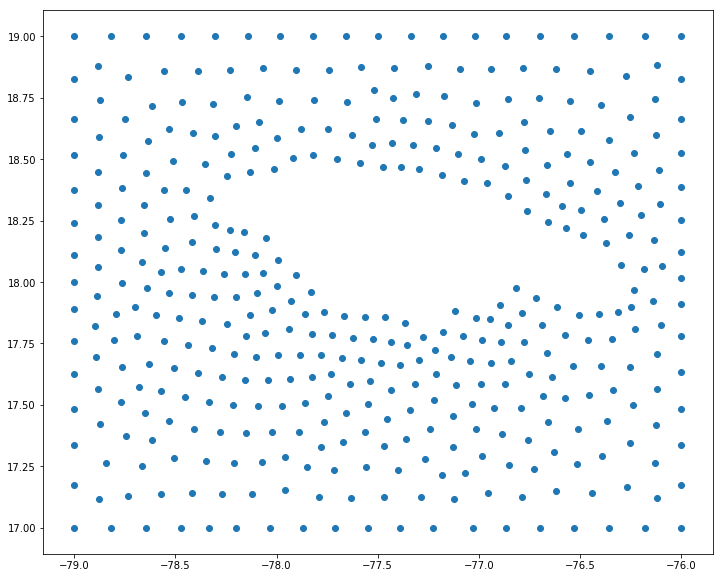

In [63]:
#plot xy points
plt.figure(figsize=(12,10))
plt.scatter(xy.x, xy.y)

In [64]:
power,pn=pd.read_csv(msh,header=4,skiprows=nn,nrows=0,delimiter='=')

In [65]:
pn,s = pn.split(';')

In [66]:
pn = int(pn)

In [67]:
pr=pd.read_csv(msh,skiprows=nn+5,header=None,delimiter=';',engine='python',nrows=pn,names=['a'])

### EDGES

In [68]:
edge2,ne=pd.read_csv(msh,header=4,skiprows=nn+pn+1,nrows=0,delimiter='=')

In [69]:
ne = int(ne)

In [70]:
ne

112

In [71]:
e2=pd.read_csv(msh,skiprows=nn+pn+6,header=None,delimiter=';',engine='python',nrows=ne,names=['a','b','c'])

In [72]:
e2.head()

,a,b,c
0,67,91,0
1,49,72,0
2,78,97,0
3,9,42,0
4,39,58,0


In [73]:
e2.tail()

,a,b,c
107,29,47,0
108,32,43,0
109,60,102,0
110,30,44,0
111,77,98,0


In [74]:
#get edge lon/lat
elon=[]
elat=[]
for index, row in e2.loc[:,['a','b']].iterrows():
    i, j = row['a'], row['b']
    elon.append(xy.x[i])
    elat.append(xy.y[i])
    elon.append(xy.x[j])
    elat.append(xy.y[j])


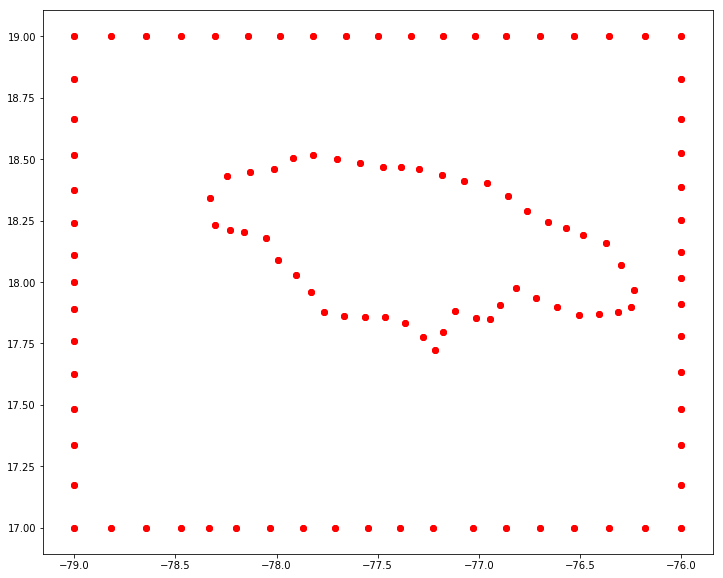

In [75]:
#plot e2
plt.figure(figsize=(12,10))
plt.scatter(elon,elat,c='r')


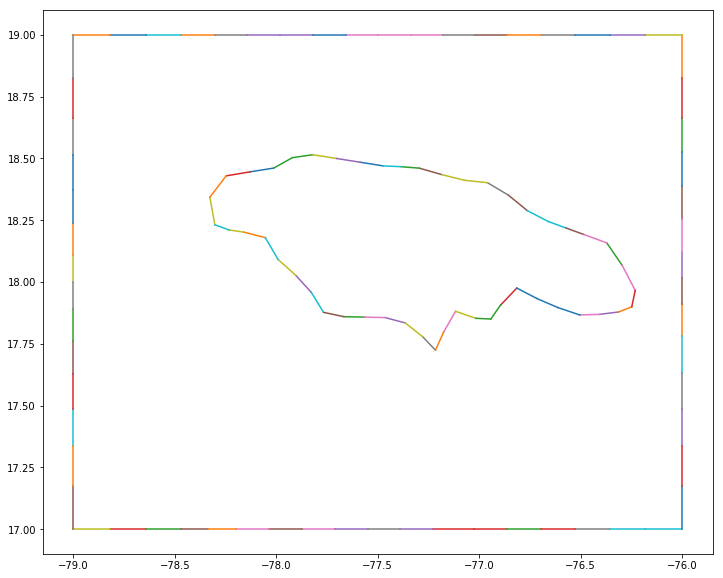

In [76]:
#plot e2
plt.figure(figsize=(12,10))
for index, row in e2.loc[:,['a','b']].iterrows():
    i, j = row['a'], row['b']
    p1 = (xy.x[i],xy.x[j])
    p2 = (xy.y[i],xy.y[j])
    plt.plot(p1,p2)

In [77]:
sh = zip(elon,elat)

In [78]:
csh = [sh[i:i + 2] for i in xrange(0, len(sh), 2)]

In [79]:
mlist=[]
for i in range(len(csh)):
     mlist.append(geometry.LineString(csh[i]))

In [80]:
print mlist[4]

LINESTRING (-77.81992933023007 19, -77.98214964448323 19)


In [81]:
sall = geometry.MultiLineString(mlist)

In [82]:
c = ops.linemerge(sall)

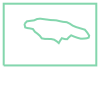

In [83]:
c

In [84]:
len(c)

2

### TRIANGLES

In [85]:
edge3,n3e=pd.read_csv(msh,header=4,skiprows=nn+pn+ne+2,nrows=0,delimiter='=')

In [86]:
n3e

'708'

In [87]:
n3e = int(n3e)

In [88]:
e3=pd.read_csv(msh,skiprows=nn+pn+ne+7,header=None,delimiter=';',engine='python',nrows=n3e,names=['a','b','c','q'])

In [89]:
e3.head()

,a,b,c,q
0,166,190,216,0
1,136,168,221,0
2,235,266,363,0
3,303,360,374,0
4,283,222,359,0


In [90]:
e3.tail()

,a,b,c,q
703,91,104,134,0
704,235,230,241,0
705,261,324,276,0
706,323,345,276,0
707,324,323,276,0


In [91]:
e3['q']=3

In [92]:
e3.head()

,a,b,c,q
0,166,190,216,3
1,136,168,221,3
2,235,266,363,3
3,303,360,374,3
4,283,222,359,3


In [93]:
tri3 = e3.loc[:,['a','b','c']].values

In [94]:
tri3

array([[166, 190, 216],
       [136, 168, 221],
       [235, 266, 363],
       ..., 
       [261, 324, 276],
       [323, 345, 276],
       [324, 323, 276]])

In [95]:
xy.x.iloc[-1],xy.y.iloc[-1]

(-77.036109389521343, 17.502977974140322)

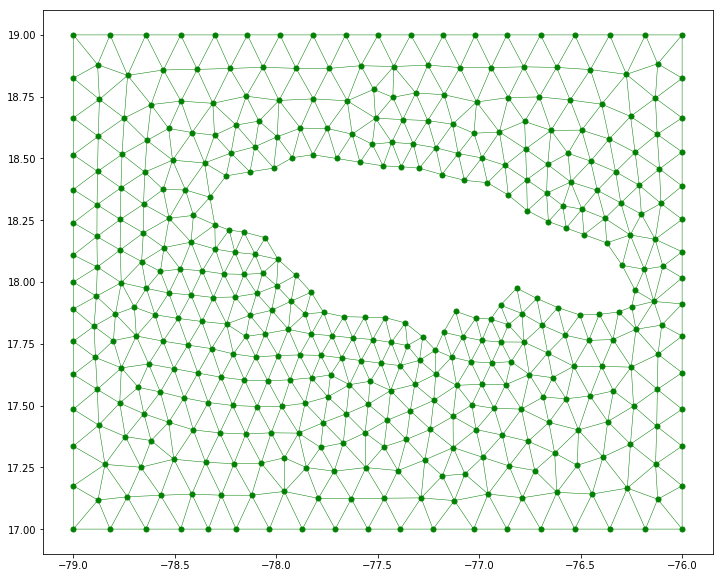

In [96]:
#plot e3
plt.figure(figsize=(12,10))
plt.triplot(xy.x, xy.y, tri3, 'go-', lw=.5, markersize=5 )
plt.show()

### Get depth

In [97]:
# Get Bathymetry
dem = erdap(**{'minlon' : -79., 'maxlon' :  -76., 'minlat' : 17., 'maxlat' : 19., 'grid_x' : xy.x, 'grid_y' : xy.y})

In [191]:
dem.val

<xarray.DataArray 'z' (latitude: 480, longitude: 720)>
array([[ -990.,  -974.,  -956., ..., -1840., -1831., -1823.],
       [ -989.,  -975.,  -958., ..., -1841., -1831., -1823.],
       [ -991.,  -976.,  -960., ..., -1844., -1834., -1826.],
       ..., 
       [-5315., -5286., -5264., ..., -2873., -2887., -2895.],
       [-5324., -5297., -5276., ..., -2872., -2885., -2894.],
       [-5332., -5305., -5282., ..., -2871., -2885., -2894.]])
Coordinates:
  * latitude   (latitude) float64 17.0 17.0 17.01 17.01 17.02 17.02 17.02 ...
  * longitude  (longitude) float64 -79.0 -79.0 -78.99 -78.99 -78.98 -78.98 ...
Attributes:
    _ChunkSizes:      [129 129]
    colorBarMaximum:  8000.0
    colorBarMinimum:  -8000.0
    colorBarPalette:  Topography
    coordsys:         geographic
    ioos_category:    Location
    long_name:        Altitude
    positive:         up
    standard_name:    altitude
    units:            m

In [98]:
dem.val.max(), dem.val.min()

(<xarray.DataArray 'z' ()>
 array(2208.0), <xarray.DataArray 'z' ()>
 array(-5892.0))

In [99]:
pp = np.argwhere(dem.ival > 0)

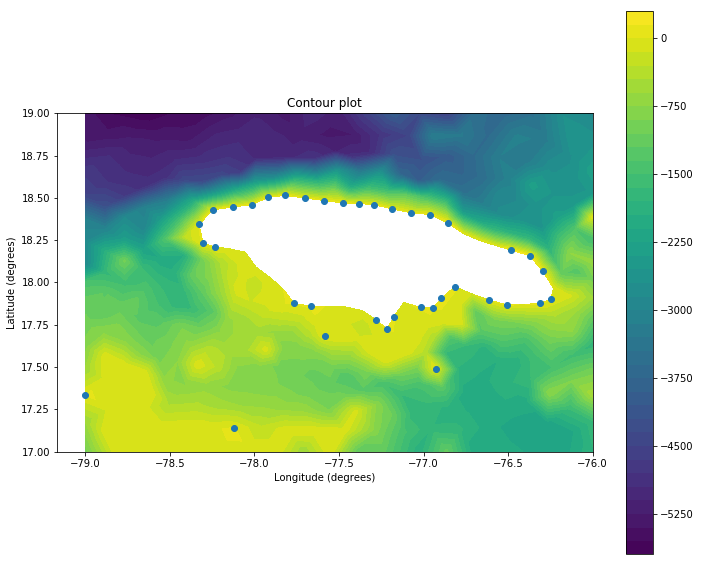

In [100]:
# plot bathymetry
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal')
plt.tricontourf(xy.x, xy.y, tri3, dem.ival, 50, )
plt.colorbar()
plt.scatter(dem.ilons.values[pp], dem.ilats.values[pp])
plt.title('Contour plot')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

In [101]:
dem.ival[dem.ival>0] = 0. # fix???

In [102]:
folder = '/Users/brey/SCHISM/test_grid/'

# Save necessary input files for Schism

### hgrid.gr3

In [103]:
grid = xy.copy()
grid = grid.loc[:,:].astype(float)

In [104]:
grid.loc[:,'z'] = - dem.ival

In [105]:
grid.index = grid.index + 1 # change index start

In [106]:
grid.head()

,x,y,z
1,-76.000000,19.000000,2894.0
2,-79.000000,17.000000,990.0
3,-76.000000,17.000000,1823.0
4,-79.000000,19.000000,5332.0
5,-77.463867,17.856055,90.0


In [107]:
grid.tail()

,x,y,z
406,-78.571280,18.042672,1784.0
407,-77.732691,17.624084,789.0
408,-77.781793,17.330545,860.0
409,-77.826854,17.789463,264.0
410,-77.036109,17.502978,871.0


In [108]:
g3file=folder+'hgrid.gr3'

In [109]:
with open(g3file,'w') as f:
    f.write('\t uniform.gr3\n')
    f.write('\t {} {}\n'.format(n3e,nn))
    

In [110]:
grid.to_csv(g3file,index=True, sep='\t', header=None,mode='a', float_format='%.10f', columns=['x','y','z'])

In [111]:
# Add one to reset the node counter
c3 = e3.copy()
c3.loc[:,['a']]=c3.loc[:,['a']]+1
c3.loc[:,['b']]=c3.loc[:,['b']]+1
c3.loc[:,['c']]=c3.loc[:,['c']]+1
c3.index = c3.index + 1 # adjust index start
c3.head()

,a,b,c,q
1,167,191,217,3
2,137,169,222,3
3,236,267,364,3
4,304,361,375,3
5,284,223,360,3


In [112]:
c3.to_csv(g3file,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

In [113]:
# identify the node numbers of boundaries
idx=[]
for i in range(len(c[0].coords)):
    bx,by = c[0].coords[i]
    idx.append(grid.loc[(grid['x'] == bx) & (grid['y'] == by)].index.values)

In [114]:
fidx = [item for sublist in idx for item in sublist]
fidx = fidx[:-1]

In [115]:
with open(g3file, 'a') as f:
    f.write('{} = Number of open boundaries\n'.format(1))
    f.write('{} = Total number of open boundary nodes\n'.format(len(fidx)))
    f.write('{} = Number of nodes for open boundary 1\n'.format(len(fidx)))
    for item in fidx:
        f.write("%s\n" % item)

In [116]:
# identify the node numbers of boundaries
idx=[]
for i in range(len(c[1].coords)):
    bx,by = c[1].coords[i]
    idx.append(grid.loc[(grid['x'] == bx) & (grid['y'] == by)].index.values)

In [117]:
fidx = [item for sublist in idx for item in sublist]
fidx = fidx[:-1]

In [118]:
with open(g3file, 'a') as f:
    f.write('{} = Number of land boundaries\n'.format(1))
    f.write('{} = Total number of land boundary nodes\n'.format(len(fidx)))
    f.write('{} 1 = Number of nodes for land boundary 1\n'.format(len(fidx)))
    for item in fidx:
        f.write("%s\n" % item)

### hgrid.ll

In [119]:
llfile=folder+'hgrid.ll'

In [120]:
copyfile(g3file, llfile)

### manning.gr3

In [121]:
manfile=folder+'manning.gr3'

In [122]:
with open(manfile,'w') as f:
    f.write('\t 0 \n')
    f.write('\t {} {}\n'.format(n3e,nn))

In [123]:
grid['man']=.12
grid.head()

,x,y,z,man
1,-76.000000,19.000000,2894.0,0.12
2,-79.000000,17.000000,990.0,0.12
3,-76.000000,17.000000,1823.0,0.12
4,-79.000000,19.000000,5332.0,0.12
5,-77.463867,17.856055,90.0,0.12


In [124]:
grid.to_csv(manfile,index=True, sep='\t', header=None,mode='a', float_format='%.10f',columns=['x','y','man'] )

In [125]:
c3.to_csv(manfile,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

### windrot_geo2proj.gr3

In [126]:
windfile=folder+'windrot_geo2proj.gr3'

In [127]:
with open(windfile,'w') as f:
    f.write('\t 0 \n')
    f.write('\t {} {}\n'.format(n3e,nn))

In [128]:
grid['windrot']=0.000001
grid.head()

,x,y,z,man,windrot
1,-76.000000,19.000000,2894.0,0.12,0.000001
2,-79.000000,17.000000,990.0,0.12,0.000001
3,-76.000000,17.000000,1823.0,0.12,0.000001
4,-79.000000,19.000000,5332.0,0.12,0.000001
5,-77.463867,17.856055,90.0,0.12,0.000001


In [129]:
grid.to_csv(windfile,index=True, sep='\t', header=None,mode='a', float_format='%.10f',columns=['x','y','windrot'] )

In [130]:
c3.to_csv(windfile,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

## Get uvp forcing

In [131]:
meteo = gfs(**{'minlon':minlon-.1, # lat/lon window
     'maxlon':maxlon+.1,
     'minlat':minlat-.1,
     'maxlat':maxlat+.1,
     'start_date':'2013-10-28',
     'end_date':'2013-10-29',
    })

In [132]:
xx, yy = np.meshgrid(meteo.uvp.longitude.data, meteo.uvp.latitude.data)

In [133]:
zero = np.zeros(meteo.uvp.prmslmsl.data.shape)

In [134]:
tlist = (meteo.uvp.time.data - meteo.uvp.time.data[0]).astype('timedelta64[s]')/3600.

In [135]:
tlist = tlist.astype(float)/24.

In [136]:
udate = pd.to_datetime(meteo.uvp.time[0].data).strftime('%Y-%m-%d')

In [137]:
bdate = pd.to_datetime(meteo.uvp.time[0].data).strftime('%Y %m %d %H').split(' ')

In [138]:
bdate = [int(q) for q in bdate]

In [139]:
sout= xr.Dataset({'prmsl':(['time', 'nx_grid', 'ny_grid'], meteo.uvp.prmslmsl.data),
                  'uwind':(['time','nx_grid','ny_grid'], meteo.uvp.ugrd10m.data),
                  'vwind':(['time','nx_grid','ny_grid'], meteo.uvp.vgrd10m.data),
                  'spfh':(['time','nx_grid','ny_grid'], zero),
                  'stmp':(['time','nx_grid','ny_grid'], zero),
                  'lon':(['nx_grid','ny_grid'], xx),
                  'lat':(['nx_grid','ny_grid'], yy)},
             coords={'time':tlist})

In [140]:
sout.attrs={'description' : 'Schism forsing',
    'history' :'JRC Ispra European Commission',
    'source' : 'netCDF4 python module'}

In [141]:
sout.time.attrs={   'long_name':      'Time',
                    'standard_name':  'time',
                    'base_date':      bdate,
                    'units':          udate}

In [142]:
sout.lon.attrs={'units': 'degrees_east',
               'long_name': 'Longitude',
               'standard_name':'longitude'}

In [143]:
sout.lat.attrs={'units': 'degrees_north',
               'long_name': 'Latitude',
               'standard_name':'latitude'}

In [144]:
sout.prmsl.attrs={'units': 'Pa',
               'long_name': 'Pressure reduced to MSL',
               'standard_name':'air_pressure_at_sea_level'}

In [145]:
sout.uwind.attrs={'units': 'm/s',
               'long_name': 'Surface Eastward Air Velocity',
               'standard_name':'eastward_wind'}

In [146]:
sout.vwind.attrs={'units': 'm/s',
               'long_name': 'Surface Northward Air Velocity',
               'standard_name':'northward_wind'}

In [147]:
sout.spfh.attrs={'units': '1',
               'long_name': 'Surface Specific Humidity (2m AGL)',
               'standard_name':'specific_humidity'}

In [148]:
sout.spfh.attrs={'units': 'degrees',
               'long_name': 'Surface Temperature',
               'standard_name':'surface temperature'}

In [149]:
sout.to_netcdf(folder+'sflux/sflux_air_1.001.nc')

In [150]:
sfi = pd.read_csv(folder+'sflux/sflux_inputs.txt',header=0,sep='=')

In [151]:
sin = list(bdate)

In [152]:
sin.extend([0,' '])

In [153]:
sfi['&sflux_inputs']=sin

In [154]:
sfi

,&sflux_inputs
start_year,2013
start_month,10
start_day,28
start_hour,0
utc_start,0
/,


In [155]:
with open(folder+'sflux/sflux_inputs.txt', 'w') as f:
    f.write('&sflux_inputs\n')
    sfi.iloc[:-1,:].to_csv(f,sep='=', header=False, line_terminator = ',\n')
    f.write('/ \n\n')

### param.in

In [231]:
with open(folder+'param.in') as f:
    for line in f:
        if 'rnday' in line:
            print line
            rnday = line

  rnday = 0.6 !total run time in days 



In [232]:
old = rnday
new = rnday.replace('0.6','1.6')

In [233]:
old, new

('  rnday = 0.6 !total run time in days \n',
 '  rnday = 1.6 !total run time in days \n')

In [237]:
for line in fileinput.input(folder+'param.in', inplace = 1): 
      print line.replace(old, new),

In [236]:
fileinput.close()

## Execute Schism

In [194]:
ex=subprocess.Popen(args=[folder+'./launchSchism.sh'], cwd=folder, shell=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE, bufsize=1)
for line in iter(ex.stdout.readline, b''):
    print line,
ex.stdout.close()

  recs_his=           1
  recs_his=           1
  recs_his=           1
  recs_his=           1
  recs_his=           2
  recs_his=           2
  recs_his=           2
  recs_his=           2
  recs_his=           3
  recs_his=           3
  recs_his=           3
  recs_his=           3
  recs_his=           4
  recs_his=           4
  recs_his=           4
  recs_his=           4
  recs_his=           5
  recs_his=           5
  recs_his=           5
  recs_his=           5
  recs_his=           6
  recs_his=           6
  recs_his=           6
  recs_his=           6
  recs_his=           7
  recs_his=           7
  recs_his=           7
  recs_his=           7
  recs_his=           8
  recs_his=           8
  recs_his=           8
  recs_his=           8
  recs_his=           9
  recs_his=           9
  recs_his=           9
  recs_his=           9
  recs_his=          10
  recs_his=          10
  recs_his=          10
  recs_his=          10
  recs_his=          11
  recs_his=     

### Data Visualization

In [169]:
out = xr.open_dataset(folder+'outputs/schism_history.nc')

In [170]:
out

<xarray.Dataset>
Dimensions:         (np_global: 410, nvrt: 2, ocean_time: 38)
Coordinates:
  * ocean_time      (ocean_time) datetime64[ns] 2015-10-28T00:55:44.898392064 ...
Dimensions without coordinates: np_global, nvrt
Data variables:
    ocean_time_day  (ocean_time) datetime64[ns] ...
    ocean_time_str  (ocean_time) |S15 ...
    kbp00           (ocean_time, np_global) int32 ...
    idry            (ocean_time, np_global) int32 ...
    WATLEV          (ocean_time, np_global) float32 ...
    Uwind           (ocean_time, np_global) float32 ...
    Vwind           (ocean_time, np_global) float32 ...
    davx            (ocean_time, np_global) float32 ...
    davy            (ocean_time, np_global) float32 ...
    znl             (ocean_time, np_global, nvrt) float32 ...
    qnon            (ocean_time, np_global, nvrt) float32 ...

In [171]:
h=out.WATLEV[:]

In [172]:
h.mean()

<xarray.DataArray 'WATLEV' ()>
array(-0.0007721315487287939)

In [173]:
t = out.variables['ocean_time_str'][:]
t.values

array(['20151028.010000', '20151028.020000', '20151028.030000',
       '20151028.040000', '20151028.050000', '20151028.060000',
       '20151028.070000', '20151028.080000', '20151028.090000',
       '20151028.100000', '20151028.110000', '20151028.120000',
       '20151028.130000', '20151028.140000', '20151028.150000',
       '20151028.160000', '20151028.170000', '20151028.180000',
       '20151028.190000', '20151028.200000', '20151028.210000',
       '20151028.220000', '20151028.230000', '20151029.000000',
       '20151029.010000', '20151029.020000', '20151029.030000',
       '20151029.040000', '20151029.050000', '20151029.060000',
       '20151029.070000', '20151029.080000', '20151029.090000',
       '20151029.100000', '20151029.110000', '20151029.120000',
       '20151029.130000', '20151029.140000'],
      dtype='|S15')

In [174]:
from matplotlib import animation,rc

rc('animation',html='html5')
plt.rcParams["animation.html"] = "jshtml"

In [175]:
def anim(z,t,title=None):
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    ax.set_aspect('equal')
    v=np.linspace(z.min(),z.max(),10,endpoint=True)
    ims = []
    for i in tqdm(range(len(t))):
        im = ax.tricontourf(grid.x, grid.y, tri3, z[i,:], v, vmin=z.min(), vmax=z.max())
#        im = ax.contourf(x,y,z[i,:,:],v,vmin=v1,vmax=v2,latlon=True)
        add_arts = im.collections
        text = 'time={}'.format(t[i])
        #te = ax.text(90, 90, text)
        an = ax.annotate(text, xy=(0.05, 1.05), xycoords='axes fraction')
        ims.append(add_arts + [an])
    ax.set_title(title)    
#cbar_ax = fig.add_axes([0.05, 0.05, 0.85, 0.05])    
    cbar = fig.colorbar(im,ticks=v,orientation='vertical', extend='both')#,fraction=0.046, pad=0.04)
#plt.colorbar()
    return animation.ArtistAnimation(fig, ims, interval=200, blit=False,repeat=False)

In [176]:
%%capture
v = anim(h,t.values,title='Storm Surge')

In [177]:
v

In [179]:
out.close()